### Project 4 - Hackathon! ####
All of the code in this notebook should be considered as joint work that came from the collaboration of the members: Curtis Hope Hill, Mary McAteer, and Kathy Simon.

**Description**

In this project, our group will have four (4) hours to examine and prepare a dataset of movie reviews and build a classification model based on Sentiment Analysis. 

**The sentiment labels are:**
- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

**Imports**

In [6]:
#imports
import pandas as pd
pd.set_option('display.max_colwidth', 999)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC

np.random.seed(42)

**Cleaning and EDA**

In [8]:
#https://stackoverflow.com/questions/9652832/how-to-load-a-tsv-file-into-a-pandas-dataframe
#building training dataframe from .tsv file
df_train = pd.read_csv('./train.tsv', sep='\t')
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [9]:
#checking out the number of rows:
df_train.shape

(156060, 4)

In [10]:
#checking out nulls and dtypes:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [11]:
#looking at all instances where 'SentenceId' = 1
df_train[df_train['SentenceId'] == 1]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
58,59,1,much,2
59,60,1,of a story,2
60,61,1,a story,2
61,62,1,story,2


In [12]:
#building testing dataframe from .tsv file
df_test = pd.read_csv('./test.tsv', sep = '\t')
df_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [13]:
#checking out the number of rows:
df_test.shape

(66292, 3)

In [14]:
#baseline model for predictions:
df_train['Sentiment'].value_counts(normalize = True)

2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: Sentiment, dtype: float64

In [15]:
#number of unique sentences:
df_train['SentenceId'].nunique()

8529

In [16]:
#descriptive stats:
df_train.describe().drop('count').T

,mean,std,min,25%,50%,75%,max
PhraseId,78030.500000,45050.785842,1.0,39015.75,78030.5,117045.25,156060.0
SentenceId,4079.732744,2502.764394,1.0,1861.75,4017.0,6244.00,8544.0
Sentiment,2.063578,0.893832,0.0,2.00,2.0,3.00,4.0


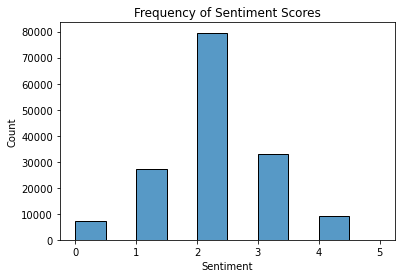

In [17]:
#beautiful bell curve!
sns.histplot(data = df_train, x = 'Sentiment', binwidth = .5, binrange = (0,5))
plt.title('Frequency of Sentiment Scores');

In [18]:
pd.DataFrame(df_train['Phrase'][df_train.SentenceId == 666])
#noting that the first instance of each unique SentenceId
#is the full review. 

,Phrase
15529,A sleek advert for youthful anomie that never quite equals the sum of its pretensions .
15530,A sleek advert for youthful anomie
15531,A sleek advert
15532,sleek advert
15533,advert
15534,for youthful anomie
15535,youthful anomie
15536,youthful
15537,anomie
15538,that never quite equals the sum of its pretensions .


In [15]:
#building a working_df that's dropping the dups on df_train
working_df = df_train.drop_duplicates(subset = 'SentenceId')
working_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
63,64,2,"This quiet , introspective and entertaining independent is worth seeking .",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .",1
116,117,4,"A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .",3
156,157,5,Aggressive self-glorification and a manipulative whitewash .,1


In [16]:
#using bag of words to find and build on additional stop words:
cvec = CountVectorizer(analyzer = 'word', stop_words = 'english', max_features = 50)

# input for CountVectorizer is an array of strings
working_df = working_df['Phrase']

# fit_transform the vectorizer
working_words = cvec.fit_transform(working_df)

# convert output to a Numpy array
working_words = working_words.toarray()

In [17]:
#most common words from 'working_words':
working_words = cvec.get_feature_names()
print(working_words)

['action', 'audience', 'bad', 'best', 'better', 'big', 'cast', 'character', 'characters', 'comedy', 'director', 'does', 'drama', 'feel', 'film', 'films', 'fun', 'funny', 'good', 'great', 'hard', 'just', 'life', 'like', 'little', 'long', 'look', 'love', 'lrb', 'make', 'makes', 'man', 'movie', 'movies', 'new', 'old', 'people', 'performance', 'performances', 'plot', 'real', 'really', 'rrb', 'self', 'sense', 'story', 'time', 'way', 'work', 'world']


In [75]:
#Most common words where 'Sentiment' = 2
#using bag of words to find and build on additional stop words:
cvec = CountVectorizer(analyzer = 'word', stop_words = 'english', max_features = 50) 

df_sentiment2 = df_train[df_train['Sentiment'] == 2]['Phrase']

# fit_transform the vectorizer
sentiment2_words = cvec.fit_transform(df_sentiment2)

# convert output to a Numpy array
sentiment2_words = sentiment2_words.toarray()

In [76]:
#most common words from where 'Sentiment' = 2:
sentiment2_words = cvec.get_feature_names()
print(sentiment2_words)

['action', 'american', 'audience', 'bad', 'better', 'big', 'character', 'characters', 'comedy', 'director', 'does', 'drama', 'family', 'film', 'films', 'good', 'hollywood', 'human', 'just', 'life', 'like', 'little', 'long', 'look', 'love', 'lrb', 'make', 'man', 'minutes', 'movie', 'movies', 'new', 'old', 'people', 'plot', 'real', 'rrb', 'screen', 'seen', 'self', 'sense', 'story', 'things', 'time', 'war', 'way', 'work', 'world', 'year', 'young']


In [20]:
# top 25 words - no stop words
cvec_working_no_stop = CountVectorizer()
X_working_cvec_no_stop = cvec_working_no_stop.fit_transform(working_df)
X_working_cvec_df_no_stop = pd.DataFrame(X_working_cvec_no_stop.todense(), columns = cvec_working_no_stop.get_feature_names())
X_working_cvec_df_no_stop.head()

top25_words_no_stop = X_working_cvec_df_no_stop.sum().sort_values(ascending = False)[:25]
top25_words_no_stop

the      7282
and      4474
of       4398
to       3025
is       2542
it       2411
that     1938
in       1898
as       1284
but      1168
film     1154
with     1132
for      1033
movie    1008
this      994
an        962
its       934
you       853
be        676
on        651
not       608
one       576
by        559
about     534
has       527
dtype: int64

In [21]:
#forgot stop words import from sklearn at document head:
from sklearn.feature_extraction import text

stop_words = text.ENGLISH_STOP_WORDS

In [22]:
# top 25 words - with stop words (from sklearn)
cvec_working_no_stop = CountVectorizer(stop_words = stop_words)
X_working_cvec_no_stop = cvec_working_no_stop.fit_transform(working_df)
X_working_cvec_df_no_stop = pd.DataFrame(X_working_cvec_no_stop.todense(), columns = cvec_working_no_stop.get_feature_names())
X_working_cvec_df_no_stop.head()

top25_words_no_stop = X_working_cvec_df_no_stop.sum().sort_values(ascending = False)[:25]
top25_words_no_stop

film          1154
movie         1008
like           504
rrb            352
lrb            351
story          350
does           307
good           294
just           292
comedy         264
time           250
characters     233
funny          222
director       217
little         216
way            203
make           196
life           186
work           179
makes          174
love           174
bad            173
best           165
movies         159
new            153
dtype: int64

In [2]:
#Run by Kathy Simon:
#group sentiment into 0, 1 -> 1 (negative); 2 remains 2 (neutral); 3, 4 -> 3 (positive)

#group_df = working_df.copy()
#group_df['Sentiment'] = group_df['Sentiment'].map({0: 'Negative', 1: 'Negative', 2: 'Neutral', 3: 'Positive', 4: 'Positive'})
#group_df.head()

**Modeling**

In [23]:
#for ease of reference:
df_train.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [24]:
#setting up features and target
X = df_train['Phrase']
y = df_train['Sentiment']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    stratify = y)

1. CountVectorizer with LogReg

In [25]:
#starting modeling with CountVectorizer to vectorizer 'Phrase'
cvec = CountVectorizer(analyzer = 'word',                        
                       stop_words = stop_words, 
                       max_features = 2000)
lr = LogisticRegression(max_iter = 10_000)

In [26]:
#pipeline for cvec with lr
cvec_logreg_pipe = Pipeline([('cvec', cvec),
               ('logreg', lr),
              ])
cvec_logreg_pipe.fit(X_train, y_train)
cvec_logreg_pipe.score(X_train, y_train), cvec_logreg_pipe.score(X_test, y_test)

(0.6265138408304498, 0.6037421504549533)

Running the Pipeline with different 'max_features' - Accuracy(train, test):
* none  -   (0.714540881712162, 0.6431821094450852)
* 500   -   (0.570277457388184, 0.5602973215429963)
* 1000  -   (0.5952998846597463, 0.5779828271177753)
* 2000  -   (0.6282119056773036, 0.6008586441112392)
* 3000  -   (0.6448080866333461, 0.6134499551454569)

In [27]:
#generating predictions:
preds_0 = cvec_logreg_pipe.predict(X_test)

In [28]:
#printing classification report:
print(classification_report(preds_0, y_test))

              precision    recall  f1-score   support

           0       0.19      0.51      0.27       514
           1       0.25      0.50      0.34      2789
           2       0.89      0.64      0.74     22184
           3       0.39      0.52      0.45      4907
           4       0.25      0.56      0.34       818

    accuracy                           0.60     31212
   macro avg       0.39      0.55      0.43     31212
weighted avg       0.73      0.60      0.64     31212



<Figure size 576x576 with 0 Axes>

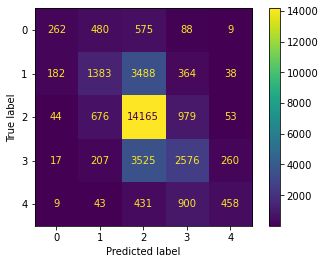

In [29]:
#plotting confusion matrix:
plt.figure(figsize = (8, 8));
plot_confusion_matrix(cvec_logreg_pipe, 
                      X_test, y_test, 
                      cmap = 'viridis', 
                      values_format = 'd');

- Exploring n-grams:

In [30]:
cvec = CountVectorizer(analyzer = 'word',                        
                       stop_words = stop_words, 
                       max_features = None,
                       ngram_range = (2,3))
lr = LogisticRegression(max_iter = 10_000)

In [31]:
#pipeline for cvec with lr, searching bi-grams and tri-grams
cvec_logreg_pipe = Pipeline([('cvec', cvec),
               ('logreg', lr)])

cvec_logreg_pipe.fit(X_train, y_train)
cvec_logreg_pipe.score(X_train, y_train), cvec_logreg_pipe.score(X_test, y_test)

(0.7747661155965654, 0.6243752402921953)

In [32]:
#generating predictions:
preds_1 = cvec_logreg_pipe.predict(X_test)

In [33]:
#printing classification report:
print(classification_report(preds_1, y_test))

              precision    recall  f1-score   support

           0       0.29      0.52      0.37       791
           1       0.35      0.57      0.43      3392
           2       0.89      0.65      0.75     21806
           3       0.38      0.59      0.46      4241
           4       0.30      0.57      0.39       982

    accuracy                           0.62     31212
   macro avg       0.44      0.58      0.48     31212
weighted avg       0.73      0.62      0.65     31212



<Figure size 576x576 with 0 Axes>

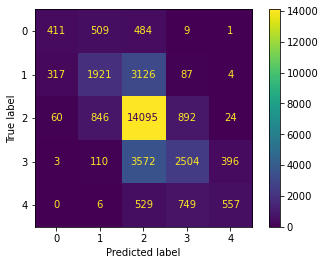

In [34]:
#plotting confusion matrix:
plt.figure(figsize = (8, 8));
plot_confusion_matrix(cvec_logreg_pipe, 
                      X_test, y_test, 
                      cmap = 'viridis', 
                      values_format = 'd');

2. CountVectorizer with MultinomialNB

In [35]:
#re-instatiating cvec, instantiating MultinomialNB
cvec = CountVectorizer(analyzer = 'word',                        
                       stop_words = stop_words, 
                       max_features = 2000)
nb = MultinomialNB()

In [36]:
#pipeline for cvec with nb:
cvec_nb_pipe = Pipeline([('cvec', cvec), 
                        ('nb', nb)])

cvec_nb_pipe.fit(X_train, y_train)
cvec_nb_pipe.score(X_train, y_train), cvec_nb_pipe.score(X_test, y_test)

(0.604935601691657, 0.5887799564270153)

In [37]:
#generating predictions:
preds_2 = cvec_nb_pipe.predict(X_test)

In [38]:
#printing classification report:
print(classification_report(preds_2, y_test))

              precision    recall  f1-score   support

           0       0.15      0.52      0.24       411
           1       0.20      0.51      0.29      2184
           2       0.91      0.61      0.73     23817
           3       0.33      0.52      0.40      4178
           4       0.19      0.56      0.28       622

    accuracy                           0.59     31212
   macro avg       0.36      0.54      0.39     31212
weighted avg       0.76      0.59      0.64     31212



<Figure size 576x576 with 0 Axes>

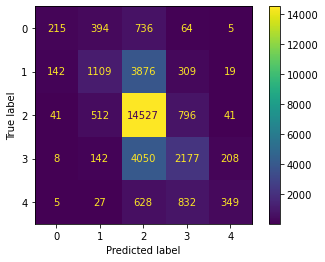

In [39]:
#plotting confusion matrix:
plt.figure(figsize = (8, 8));
plot_confusion_matrix(cvec_nb_pipe, 
                      X_test, y_test, 
                      cmap = 'viridis', 
                      values_format = 'd');

3. CountVectorizer with KNN

In [40]:
cvec = CountVectorizer(analyzer = 'word',                        
                       stop_words = stop_words )
                       
knn = KNeighborsClassifier()

In [41]:
#pipeline for cvec with knn:
pipe_knn_cv = Pipeline([
    ('cvec', cvec),
    ('knn', knn)
])

pipe_knn_cv.fit(X_train, y_train)
pipe_knn_cv.score(X_train, y_train), pipe_knn_cv.score(X_test, y_test)

(0.7223263488401896, 0.6182878380110214)

In [42]:
#generating predictions:
preds_knn = pipe_knn_cv.predict(X_test)

In [43]:
#printing classification report:
print(classification_report(preds_knn, y_test))

              precision    recall  f1-score   support

           0       0.33      0.48      0.39       966
           1       0.39      0.53      0.45      4009
           2       0.87      0.65      0.74     21143
           3       0.38      0.57      0.45      4353
           4       0.24      0.60      0.34       741

    accuracy                           0.62     31212
   macro avg       0.44      0.57      0.48     31212
weighted avg       0.71      0.62      0.65     31212



<Figure size 576x576 with 0 Axes>

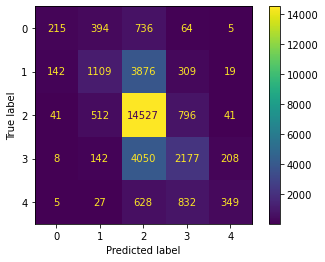

In [44]:
#plotting confusion matrix:
plt.figure(figsize = (8, 8));
plot_confusion_matrix(cvec_nb_pipe, 
                      X_test, y_test, 
                      cmap = 'viridis', 
                      values_format = 'd');

4. TF-IDF with LogReg

In [45]:
#starting modeling with CountVectorizer to vectorizer 'body'
tvec = TfidfVectorizer(analyzer = 'word',                        
                       stop_words = stop_words, 
                       max_features = 3000)

In [46]:
#pipeline for tvec with lr:
tvec_lr_pipe = Pipeline([
    ('tvec', tvec),
    ('logreg', lr)])

tvec_lr_pipe.fit(X_train, y_train)
tvec_lr_pipe.score(X_train, y_train), tvec_lr_pipe.score(X_test, y_test)

(0.6333701781366141, 0.6099256696142509)

Running the Pipeline with different 'max_features' - Accuracy(train, test):
* none  -   (0.6822696398820967, 0.6323529411764706)
* 500   -   (0.5672097270280662, 0.5618031526336025)
* 1000  -   (0.588876073305139, 0.5803537101114956)
* 2000  -   (0.6186562860438293, 0.5986479559143919)
* 3000  -   (0.6333701781366141, 0.6099256696142509)

In [47]:
#generating predictions:
preds_3 = tvec_lr_pipe.predict(X_test)

In [48]:
#printing classification report:
print(classification_report(preds_3, y_test))

              precision    recall  f1-score   support

           0       0.17      0.56      0.26       432
           1       0.29      0.50      0.37      3112
           2       0.88      0.65      0.75     21574
           3       0.43      0.52      0.47      5408
           4       0.22      0.58      0.31       686

    accuracy                           0.61     31212
   macro avg       0.40      0.56      0.43     31212
weighted avg       0.72      0.61      0.65     31212



<Figure size 576x576 with 0 Axes>

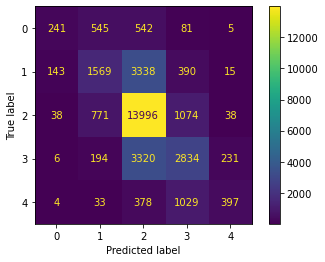

In [49]:
#plotting confusion matrix:
plt.figure(figsize = (8, 8));
plot_confusion_matrix(tvec_lr_pipe, 
                      X_test, y_test, 
                      cmap = 'viridis', 
                      values_format = 'd');

5. TF-IDF with MultinomialNB

In [50]:
#pipeline for tvec with nb:
tvec_nb_pipe = Pipeline([('tvec', cvec), 
                        ('nb', nb)])

tvec_nb_pipe.fit(X_train, y_train)
tvec_nb_pipe.score(X_train, y_train), tvec_nb_pipe.score(X_test, y_test)

(0.6705674099705241, 0.609765474817378)

In [20]:
#generating predictions:
preds_4 = tvec_nb_pipe.predict(X_test)

In [52]:
#printing classification report:
print(classification_report(preds_4, y_test))

              precision    recall  f1-score   support

           0       0.28      0.43      0.34       899
           1       0.41      0.49      0.45      4469
           2       0.79      0.69      0.73     18357
           3       0.50      0.52      0.51      6350
           4       0.30      0.49      0.37      1137

    accuracy                           0.61     31212
   macro avg       0.45      0.52      0.48     31212
weighted avg       0.64      0.61      0.62     31212



<Figure size 576x576 with 0 Axes>

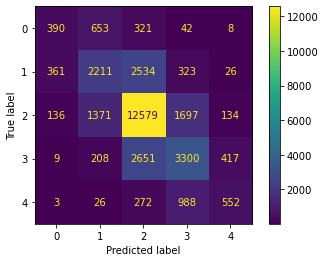

In [53]:
#plotting confusion matrix:
plt.figure(figsize = (8, 8));
plot_confusion_matrix(tvec_nb_pipe, 
                      X_test, y_test, 
                      cmap = 'viridis', 
                      values_format = 'd');

6a. CountVectorizer with Support Vector Machine

In [54]:
cvec = CountVectorizer(analyzer = 'word',                        
                       stop_words = stop_words, 
                       max_features = 2000)                     
svc = SVC(C = 1,
         degree = 2, 
         kernel = 'rbf',
         gamma = 'scale')

In [55]:
#pipe_svc = Pipeline([
#    ('cvec', cvec),
#    ('svc', svc)])

#pipe_svc.fit(X_train, y_train)
#pipe_svc.score(X_train, y_train), pipe_svc.score(X_test, y_test)
#this was run on Curtis Hill's computer, he got the output for the team. 

In [56]:
#output from above cell:
#Train = 0.7176246315519672, Test = 0.6335704216327054

In [ ]:
#preds_5a = pipe_svc.predict(X_test)

In [ ]:
#print(classification_report(preds_5a, y_test))

In [ ]:
#plt.figure(figsize = (8, 8));
#plot_confusion_matrix(pipe_svc, 
#                      X_test, y_test, 
#                      cmap = 'viridis', 
#                      values_format = 'd');

6b. TF-IDF with Support Vector Machine

In [57]:
tfidf = TfidfVectorizer(stop_words= stop_words, 
                             max_features= None,
                            ngram_range= (1,1))

In [58]:
#svc_pipe = Pipeline([
#    ('cvec', cvec),
#    ('svc', svc)])

#svc_pipe.fit(X_train, y_train)
#svc_pipe.score(X_train, y_train), svc_pipe.score(X_test, y_test)
#this was run on Curtis Hill's computer, he got the output for the team. 

In [59]:
#output from above cell:
#Train = 0.7743255799051647, Test = 0.6586569268230168

In [ ]:
#svm_class_report = classification_report(y_test, svm_predict)
#print(svm_class_report)

In [ ]:
#plt.figure(figsize = (8, 8));
#plot_confusion_matrix(svc_pipe, 
#                      X_test, y_test, 
#                      cmap = 'viridis', 
#                      values_format = 'd');

In [84]:
#Again, the SVM was run on Curtis Hill's computer, he got the output for the team. 

- TF-IDF has performed the best on our testing data so far. 

**GridSearching**

In [60]:
pipe_params = {
    'cvec__max_features': [None, 500, 1_000, 1_500, 2_000, 2_500, 3_000], 
    'cvec__min_df': [1, 2, 3], 
    'cvec__max_df': [1.0, .75, .85, .95],
    'cvec__ngram_range': [(1, 1), (1, 2), (1,3), (2,3)]
}

In [61]:
#instantiating GridSearchCV.
gs_cvec = GridSearchCV(cvec_nb_pipe, 
                  param_grid = pipe_params, 
                  cv = 5, 
                  verbose = 1)

In [62]:
#Fiting GridSearch to training data:
#gs_cvec.fit(X_train, y_train)
#gs_cvec.best_params_

#Did not have time to run GridSearch

**Model Evalution**

In [63]:
#re-initializing:
cvec = CountVectorizer(analyzer = 'word',                        
                       stop_words = stop_words, 
                       max_features = 2000)
lr = LogisticRegression(max_iter = 10_000)

In [64]:
#re-initializing:
cvec_logreg_pipe = Pipeline([('cvec', cvec),
               ('logreg', lr),
              ])
cvec_logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=2000,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
            

In [65]:
#generating predictions for testing data from cvec, lr pipeline:
df_test['preds'] = cvec_logreg_pipe.predict(df_test['Phrase'])

In [74]:
#looking at value_counts for testing predictions:
df_test['preds'].value_counts()

2    48575
3     9857
1     5188
4     1646
0     1026
Name: preds, dtype: int64

In [67]:
#Predictions for test data set using the pipeline with Support Vector Machines and Tfidf Vectorizer
#test['predictions'] = pipe_svc_2.predict(test['Phrase'])

#test['predictions'].value_counts()
#From Curtis Hill